In [15]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Function to load images and labels from a dataset folder
def load_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    for label in label_names:
        label_path = os.path.join(dataset_path, label)
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Load dataset
dataset_path = 'fish_dt'  # Replace with your actual dataset path
images, labels = load_dataset(dataset_path)

# Convert images to grayscale
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

# Apply LBP
def apply_lbp(image, num_points=24, radius=8):
    lbp = local_binary_pattern(image, num_points, radius, method='uniform')
    return lbp

# Apply LDP
def apply_ldp(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle_bins = np.int32(8 * angle / 360)  # Quantize the angle to 8 bins
    return angle_bins

# Compute histogram
def compute_histogram(image, bins=16):
    hist, _ = np.histogram(image.ravel(), bins=bins, range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Apply BWT (Block-wise Truncation)
def apply_bwt(image, blocks=(8, 8)):
    features = []
    h, w = image.shape
    (bx, by) = blocks
    xsteps = np.linspace(0, w, bx + 1, dtype=int)
    ysteps = np.linspace(0, h, by + 1, dtype=int)
    for i in range(1, len(ysteps)):
        for j in range(1, len(xsteps)):
            block = image[ysteps[i-1]:ysteps[i], xsteps[j-1]:xsteps[j]]
            hist = np.histogram(block, bins=256, range=(0, 256))[0] / (block.shape[0] * block.shape[1])
            features.extend(hist)
    return features

# Apply Hough Transform
def apply_hough(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    return len(lines) if lines is not None else 0

# Convert labels to numerical values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Function to train and evaluate classifiers
def train_and_evaluate_model(X_train, X_test, y_train, y_test, classifier):
    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Extract color features from YCbCr channels
def extract_color_features(image, bins):
    # Convert the image from grayscale to BGR to YCbCr color space
    gray_bgr_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    ycbcr_image = cv2.cvtColor(gray_bgr_image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(ycbcr_image)
    features = []
    for channel in channels:
        lbp_image = apply_lbp(channel)
        lbp_hist_features = compute_histogram(lbp_image, bins)
        ldp_image = apply_ldp(channel)
        ldp_hist_features = compute_histogram(ldp_image, bins)
        features.extend(np.hstack((lbp_hist_features, ldp_hist_features)))
    
    # Convert the original image to grayscale for BWT and Hough transform features
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bwt_features = apply_bwt(gray_image)
    hough_features = [apply_hough(gray_image)]
    
    features.extend(bwt_features)
    features.extend(hough_features)
    
    return features

# Evaluate YCbCr channel features with different histogram bin sizes
bin_sizes = [8, 16, 32, 64, 128, 256]
results = []

for bins in bin_sizes:
    ycbcr_features_list = [extract_color_features(image, bins) for image in images]
    X_train, X_test, y_train, y_test = train_test_split(ycbcr_features_list, numeric_labels, test_size=0.2, random_state=42)
    accuracy, precision, recall, f1 = train_and_evaluate_model(X_train, X_test, y_train, y_test, AdaBoostClassifier(n_estimators=100, random_state=42))
    results.append((bins, accuracy, precision, recall, f1))

# Print results in a tabular format
print(f"{'Bins':<10}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1 Score':<10}")
for bins, accuracy, precision, recall, f1 in results:
    print(f"{bins:<10}{accuracy:<10.4f}{precision:<10.4f}{recall:<10.4f}{f1:<10.4f}")


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

Bins      Accuracy  Precision Recall    F1 Score  
8         0.8771    0.8671    0.8771    0.8712    
16        0.8857    0.8795    0.8857    0.8822    
32        0.9029    0.8939    0.9029    0.8963    
64        0.9029    0.8939    0.9029    0.8963    
128       0.9029    0.8939    0.9029    0.8963    
256       0.9029    0.8939    0.9029    0.8963    


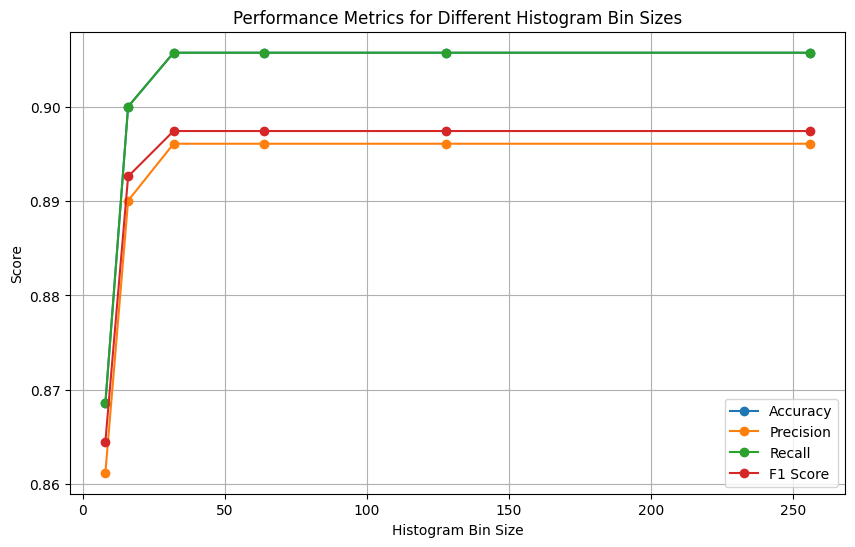

In [14]:
import matplotlib.pyplot as plt
bins, accuracy, precision, recall, f1 = zip(*results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(bins, accuracy, marker='o', label='Accuracy')
plt.plot(bins, precision, marker='o', label='Precision')
plt.plot(bins, recall, marker='o', label='Recall')
plt.plot(bins, f1, marker='o', label='F1 Score')
plt.xlabel('Histogram Bin Size')
plt.ylabel('Score')
plt.title('Performance Metrics for Different Histogram Bin Sizes')
plt.legend()
plt.grid(True)
plt.show()